# Głęboka sieć neuronowa
Sieć rozpoznaje choroby liści mango

## Instalacja potrzbnych bibliotek 

In [3]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
  Using cached matplotlib-3.8.2-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl (300.9 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp311-cp311-win_amd64.whl (2.7 MB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl (938 kB)
  Using cached numpy-1.26.3-cp311-cp311-win_amd64.whl (15.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.25.2-cp310-abi3-win_amd64.whl (413 kB)
  Using cached grpcio-1.60.1-cp311-cp311-win_amd64.whl (3.7 MB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-no


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install tensorflow-cpu


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.2
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  23.5.26
fonttools                    4.47.2
gast                         0.5.4
google-auth                  2.27.0
google-auth-oauthlib         1.2.0
google-pasta                 0.2.0
grpcio                       1.60.1
h5py                         3.10.0
idna                         3.6
ipykernel                    6.29.0
ipython                      8.21.0
jedi                         0.19.1
jupyter_client               8.6.0
jupy


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Zaimportowanie potrzbnych bibliotek 

In [339]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Przygotowanie danych

### Nazwa katalogu i klas/chorób liści

In [251]:
dataDir = 'MangoLeafBD Dataset'

In [259]:
class_names =["Anthracnose - 0", "Bacterial Canker - 1", "Cutting Weevil - 2", "Die Back - 3", "Gall Midge - 4", "Healthy - 5", "Powdery Mildew - 6", "Sooty Mould - 7"]

### Załadowanie plików

In [260]:
data = tf.keras.utils.image_dataset_from_directory(dataDir)

Found 4000 files belonging to 8 classes.


In [261]:
data_iterator = data.as_numpy_iterator()

In [262]:
batch = data_iterator.next()

In [263]:
batch[0].shape

(32, 256, 256, 3)

### Wyświetlanie i sprawdznie poprawności danych

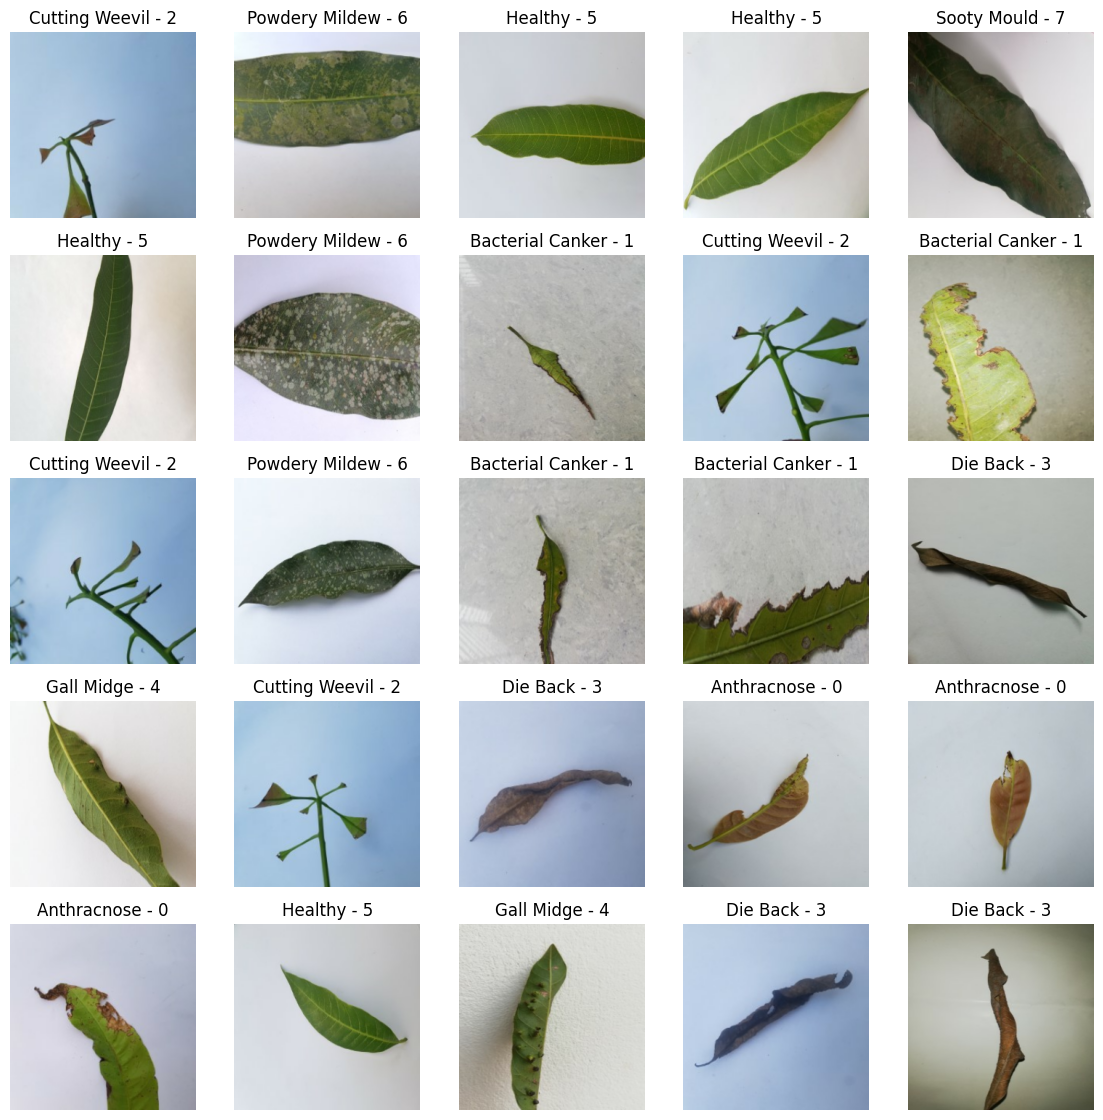

In [332]:
fig, ax = plt.subplots(5, 5, figsize=(14, 14))

for idy in range(0,5):
  #print(idy)
  for idx, img in enumerate(batch[0][(idy*5):(idy*5+5)]):
    #print ("idx = ", idx, "idy = ", idy)
    ax[idy, idx].imshow(img.astype(int))
    #print(batch[1][idx+(idy*5)])
    ax[idy, idx].title.set_text(class_names[batch[1][idx+(idy*5)]])
    ax[idy, idx].axis('off')
    


### Przeskalowanie danych 
Obrazy w RGB maja rozmiary od 0 do 255, na potrzeby sieci przeskalowno je na wartości od 0 do 1

In [267]:
data = data.map(lambda x,y: (x/255, y))

In [268]:
batchS = data.as_numpy_iterator().next()

In [338]:
fig, ax = plt.subplots(5, 5, figsize=(14, 14))

for idy in range(0,5):
    for idx, img in enumerate(batchS[0][(idy*5):(idy*5+5)]):
    ax[idy, idx].imshow(img)
    ax[idy, idx].title.set_text(class_names[batchS[1][idx+(idy*5)]])
    ax[idy, idx].axis('off')
    

IndentationError: expected an indented block after 'for' statement on line 4 (103000985.py, line 5)

### Podział danych na zbiory 
1. Treningowy - 100 batchy
2. Walidacyjny - 24 batche
3. Testowy - 1 batch

In [270]:
train_size = 100
valid_size = 24
test_size = 1

In [271]:
train_size #88
#valid_size #25
#test_size  #12
#len(data)  #125

100

#### Przypisanie danych do podzbiorów

In [272]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

In [273]:
len(train)

100

## Trenowanie sieci

### Definiowanie modelu 

In [277]:
model = Sequential()

In [278]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

### Kompilowanie modelu

In [279]:
logdir='logs'

In [280]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [336]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 30, 30, 16)      

### Uczenie modelu

In [282]:
history = model.fit(train, 
                    epochs=25, verbose=1,
                    validation_data = valid,
                    callbacks = [tensorboard_callback],
                   )

Epoch 1/25
100/100 [==============================] - 28s 270ms/step - loss: 1.1614 - accuracy: 0.5675 - val_loss: 0.6514 - val_accuracy: 0.7812
Epoch 2/25
100/100 [==============================] - 27s 267ms/step - loss: 0.4497 - accuracy: 0.8400 - val_loss: 0.3711 - val_accuracy: 0.8815
Epoch 3/25
100/100 [==============================] - 27s 265ms/step - loss: 0.2890 - accuracy: 0.8944 - val_loss: 0.4806 - val_accuracy: 0.8359
Epoch 4/25
100/100 [==============================] - 27s 265ms/step - loss: 0.1589 - accuracy: 0.9459 - val_loss: 0.2700 - val_accuracy: 0.9128
Epoch 5/25
100/100 [==============================] - 27s 266ms/step - loss: 0.1325 - accuracy: 0.9550 - val_loss: 0.3244 - val_accuracy: 0.8919
Epoch 6/25
100/100 [==============================] - 27s 267ms/step - loss: 0.1419 - accuracy: 0.9591 - val_loss: 0.3703 - val_accuracy: 0.8906
Epoch 7/25
100/100 [==============================] - 27s 267ms/step - loss: 0.0753 - accuracy: 0.9744 - val_loss: 0.2994 - val_ac

#### Wykres strat

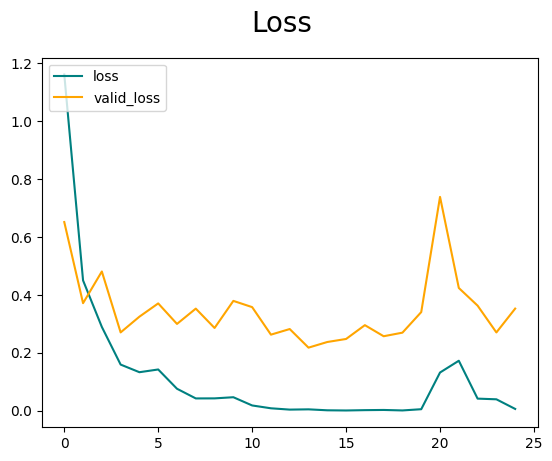

In [283]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='valid_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### Wykres dokładności

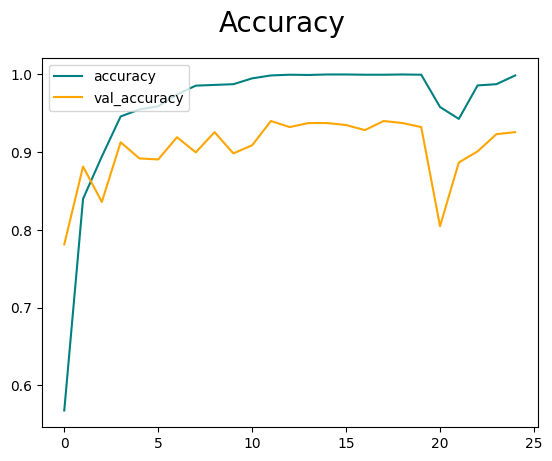

In [284]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Ocenianie modelu

In [295]:
score = model.evaluate(test, verbose = 0)
print("CNN Error: %.2f%%" % (100-score[1]*100))
print("CNN Score: %.2f%%" % (score[1]*100))

CNN Error: 6.25%
CNN Score: 93.75%


### Sprawdzenie predykcji 

#### Wylosowanie obrazu

In [325]:
import random
w = random.choice(os.listdir(dataDir)) 
m = str(dataDir + '/'+ w)
n =random.choice(os.listdir(m))

img=cv2.imread(str(m+"/"+n))

#### FUnkcja softmax

In [245]:
from numpy import exp
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

#### Załadowanie wybranego obrazu

In [ ]:
#img = cv2.imread('MangoLeafBD Dataset/Bacterial Canker/IMG_20211106_120844 (Custom).jpg')

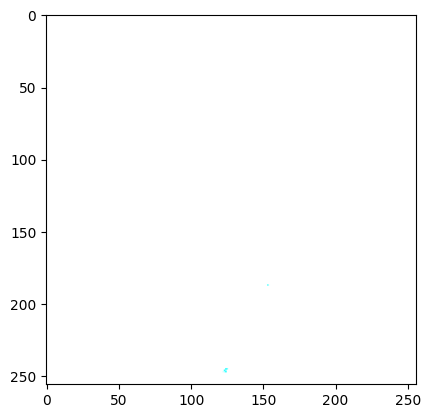

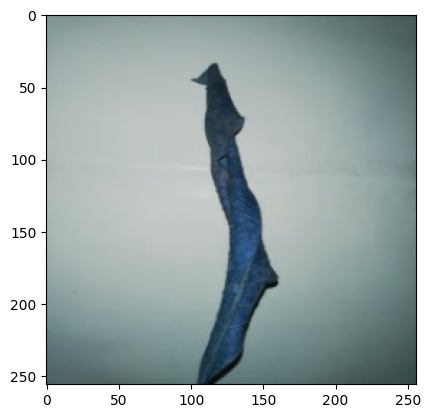

1/1 [==============================] - 0s 181ms/step
0.2797042


In [334]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))

score = softmax(yhat[0])
print(np.max(score))

In [335]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
# Dla losowego obrazu
# print('while the correct answer was {}'.format(w))

This image most likely belongs to Cutting Weevil - 2 with a 27.97 percent confidence.


### Zapisanie modelu 

In [328]:
model.save('saved_model/mangoCNNworking')

INFO:tensorflow:Assets written to: saved_model/mangoCNNworking\assets


INFO:tensorflow:Assets written to: saved_model/mangoCNNworking\assets


In [330]:
new_model=tf.keras.models.load_model('saved_model/mangoCNNworking')

In [331]:
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 30, 30, 16)      